For the current Relax Inc. challenge, the data has been divided into two csv files, 'takehome_users.csv' and 'takehome_user_engagement.csv'. The former has data on 12,000 users who signed up for the product in the last two years. The second file has a row for each day that a user logged into the product.

<div class="alert alert-block alert-info">
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday
    period , <b> identify which factors predict future user adoption </b>.
</div>


In [1]:
# Importing the required libraries and setting aesthetic settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('Set2')
plt.style.use('seaborn-pastel')

In [2]:
users = pd.read_csv('./takehome_users.csv', encoding='latin-1')
engagement = pd.read_csv('./takehome_user_engagement.csv',encoding='latin-1')

# Examining each dataframe
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Data Cleaning

In [4]:
# Let us examine the two tables in detail: Users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


The dates and categories would need to be defined as such, and the missing values would need to be dealt with. In this case, the last_session_creation_time may need to be checked with the engagement table, and any missing values can then be filled in. The invited_by_user_id column is not something that can be imputed and will be left as is. 

In [5]:
# Engagement
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


This table seems intact and there is no need for imputing missing values.

### Feature Engineering

In [6]:
# Converting dates and times to datetime types in both tables
from datetime import datetime

users.creation_time = pd.to_datetime(users.creation_time, yearfirst=True, format='%Y-%m-%d %H:%M:%S')
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')

engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [7]:
# Creating a table with the count of total number of visits per user
total_visits = engagement.groupby('user_id')['visited'].count().reset_index()
total_visits.rename(columns={'visited':'num_visits'}, inplace=True)
total_visits.num_visits = total_visits.num_visits.astype('int')
total_visits.head()

,user_id,num_visits
0,1,1
1,2,14
2,3,1
3,4,1
4,5,1


In [8]:
# Joining the two tables together: users and their corresponding number of visits to the website

users_updated = users.set_index('object_id').join(total_visits.set_index('user_id'), how='left')
users_updated.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,num_visits
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,14.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0


### One-Hot Encoding the Categorical Variables

In [9]:
# Converting the creation source column to one-hot encoded dummy categories
cat_creation_source = pd.get_dummies(users_updated.creation_source, drop_first=True)
users_updated = users_updated.join(cat_creation_source, on='object_id', lsuffix='_')
users_updated = users_updated.drop('creation_source', axis=1)

# Converting the opted_in_to_mailing_list, enabled_for_marketing_drip columns to categories
users_updated[['opted_in_to_mailing_list','enabled_for_marketing_drip']] = users_updated[['opted_in_to_mailing_list','enabled_for_marketing_drip']].astype('int')
users_updated.head()

,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,num_visits,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,10803.0,1.0,0,0,0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,316.0,14.0,1,0,0,0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1525.0,1.0,1,0,0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0,0,0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0,0,0,0


Since both the last_session_creation_time and num_visits columns counts match, it is safe to assume that we are not missing any users from the analysis. Let us now extract important values from the account creation and last login dates, as they will help in EDA.

In [10]:
# Creating new features that explore the month, day of the week and the hour of creation of users' accounts
users_updated['month_creation'] = users_updated.creation_time.dt.month
users_updated['day_of_week_creation'] = users_updated.creation_time.dt.dayofweek
users_updated['hour_creation'] = users_updated.creation_time.dt.hour

# Creating new features that explore the month, day of the week and the hour of last logins of users' accounts
users_updated['month_last_login'] = users_updated.last_session_creation_time.dt.month
users_updated['day_of_week_last_login'] = users_updated.last_session_creation_time.dt.dayofweek
users_updated['hour_last_login'] = users_updated.last_session_creation_time.dt.hour

users_updated.head()

,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,num_visits,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,month_creation,day_of_week_creation,hour_creation,month_last_login,day_of_week_last_login,hour_last_login
object_id,,,,,,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,10803.0,1.0,0,0,0,0,4,1,3,4.0,1.0,3.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,316.0,14.0,1,0,0,0,11,4,3,3.0,0.0,3.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1525.0,1.0,1,0,0,0,3,1,23,3.0,1.0,23.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0,0,0,0,5,1,8,5.0,2.0,8.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0,0,0,0,1,3,10,1.0,1.0,10.0


In [11]:
# Dropping redundant columns from users_updated
users_updated.drop(['name','email','creation_time','last_session_creation_time'], axis=1, inplace=True)

In [12]:
users_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 15 columns):
opted_in_to_mailing_list      12000 non-null int32
enabled_for_marketing_drip    12000 non-null int32
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
num_visits                    8823 non-null float64
ORG_INVITE                    12000 non-null uint8
PERSONAL_PROJECTS             12000 non-null uint8
SIGNUP                        12000 non-null uint8
SIGNUP_GOOGLE_AUTH            12000 non-null uint8
month_creation                12000 non-null int64
day_of_week_creation          12000 non-null int64
hour_creation                 12000 non-null int64
month_last_login              8823 non-null float64
day_of_week_last_login        8823 non-null float64
hour_last_login               8823 non-null float64
dtypes: float64(5), int32(2), int64(4), uint8(4)
memory usage: 1.4 MB


### Identifying Adopted Users

To analyze which users area 'adopted', one can examine the login weeks, and if any user has shown three unique values of the same week.  

In [13]:
# Creating the week_year column
engagement['week_year'] = engagement.time_stamp.dt.strftime('%U-%Y')
engagement.head(15)

,time_stamp,user_id,visited,week_year
0,2014-04-22 03:53:30,1,1,16-2014
1,2013-11-15 03:45:04,2,1,45-2013
2,2013-11-29 03:45:04,2,1,47-2013
3,2013-12-09 03:45:04,2,1,49-2013
4,2013-12-25 03:45:04,2,1,51-2013
5,2013-12-31 03:45:04,2,1,52-2013
6,2014-01-08 03:45:04,2,1,01-2014
7,2014-02-03 03:45:04,2,1,05-2014
8,2014-02-08 03:45:04,2,1,05-2014
9,2014-02-09 03:45:04,2,1,06-2014


In [14]:
# Creating a usage table that houses the users according to their week of logins and their counts
usage = engagement.groupby(['user_id', 'week_year'])['time_stamp'].count().reset_index()
usage.rename(columns={'time_stamp':'count'}, inplace=True)

In [15]:
# Any user that has logged in 3 or more times within the same week is considered adopted
usage['adopted'] = usage['count'] >= 3
usage.head(10)

,user_id,week_year,count,adopted
0,1,16-2014,1,False
1,2,01-2014,1,False
2,2,05-2014,2,False
3,2,06-2014,2,False
4,2,07-2014,1,False
5,2,10-2014,2,False
6,2,13-2014,1,False
7,2,45-2013,1,False
8,2,47-2013,1,False
9,2,49-2013,1,False


In [16]:
# Extracting list of adopted users
adopted_users = list(usage[usage.adopted == True].user_id.unique())
adopted_users[:10]

[10, 20, 42, 43, 50, 53, 63, 69, 74, 81]

In [17]:
users_updated.reset_index(inplace=True)

In [18]:
# Adding in column in users_updated to identify adopted users. This is the target variable.
# If object_id is in the list of adopted users --> True. Else --> False.
users_updated['adopted'] = users_updated.object_id.apply(lambda x: x in adopted_users).astype('int')
users_updated.head(10)

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,num_visits,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,month_creation,day_of_week_creation,hour_creation,month_last_login,day_of_week_last_login,hour_last_login,adopted
0,1,1,0,11,10803.0,1.0,0,0,0,0,4,1,3,4.0,1.0,3.0,0
1,2,0,0,1,316.0,14.0,1,0,0,0,11,4,3,3.0,0.0,3.0,0
2,3,0,0,94,1525.0,1.0,1,0,0,0,3,1,23,3.0,1.0,23.0,0
3,4,0,0,1,5151.0,1.0,0,0,0,0,5,1,8,5.0,2.0,8.0,0
4,5,0,0,193,5240.0,1.0,0,0,0,0,1,3,10,1.0,1.0,10.0,0
5,6,0,0,197,11241.0,1.0,0,0,0,0,12,1,3,12.0,3.0,3.0,0
6,7,0,1,37,NaN,1.0,0,0,1,0,12,6,13,12.0,3.0,13.0,0
7,8,1,1,74,NaN,NaN,0,1,0,0,7,2,5,NaN,NaN,NaN,0
8,9,0,0,302,NaN,NaN,0,1,0,0,11,1,4,NaN,NaN,NaN,0
9,10,1,1,318,4143.0,284.0,1,0,0,0,1,2,22,6.0,1.0,22.0,1


### Exploratory Data Analysis

We will first ask the percentage of users that adopted the product. 

Text(0.5, 1.0, 'Percentage of users that have adopted the product')

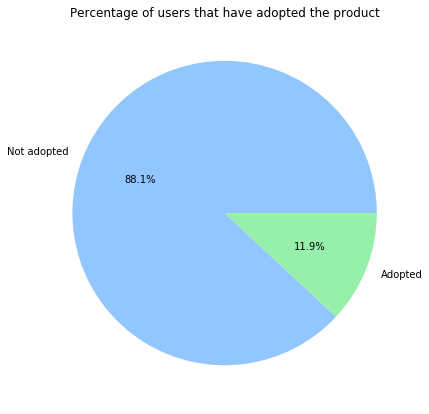

In [19]:
plt.figure(figsize=(13,7))

size_adopted = [(users_updated.adopted == 0).sum(), (users_updated.adopted == 1).sum()]
labels_adopted = 'Not adopted','Adopted'
plt.pie(size_adopted, radius=1, labels=labels_adopted, autopct='%1.1f%%')
plt.title('Percentage of users that have adopted the product')

We will analyze the number of people who opted in to mailing lists, and those who opted for the regular enabled marketing email drip. These factors can definitely influence whether a user is an adopted user.

Text(0.5, 1.0, 'Percentage of users signed up for marketing drip')

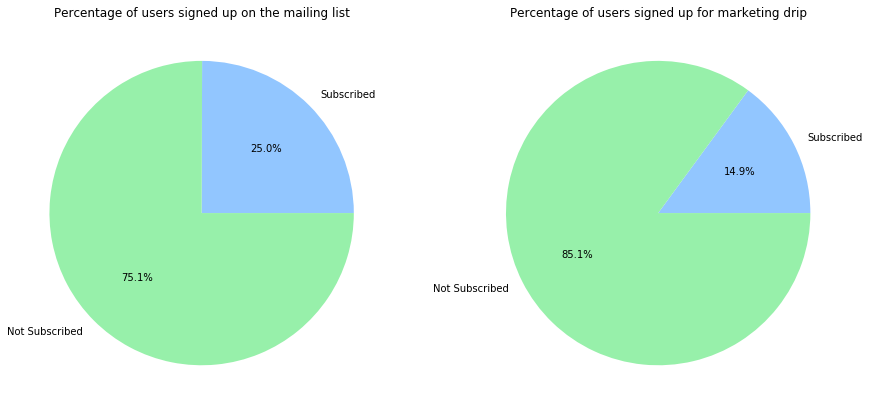

In [20]:
plt.figure(figsize=(15,8))
plt.subplot(121)

size_mailing_list = [(users_updated.opted_in_to_mailing_list == 1).sum(), (users_updated.opted_in_to_mailing_list == 0).sum()]
labels_mailing = 'Subscribed', 'Not Subscribed'
plt.pie(size_mailing_list, radius=1, labels=labels_mailing, autopct='%1.1f%%')
plt.title('Percentage of users signed up on the mailing list')

plt.subplot(122)

size_marketing = [(users_updated.enabled_for_marketing_drip == 1).sum(), (users_updated.enabled_for_marketing_drip == 0).sum()]
labels_marketing = 'Subscribed', 'Not Subscribed'
plt.pie(size_marketing, radius=1, labels=labels_marketing, autopct='%1.1f%%')
plt.title('Percentage of users signed up for marketing drip')

Text(0.5, 1.0, 'Percentage of users signed up on the mailing list')

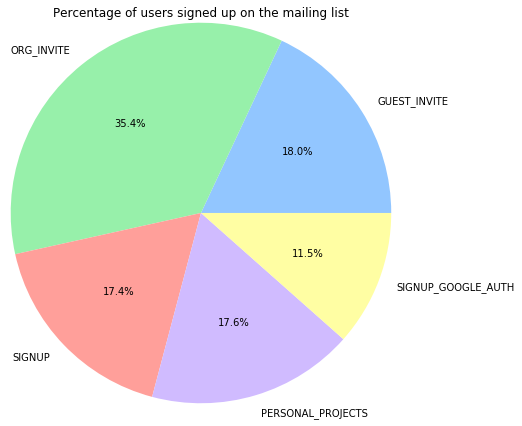

In [21]:
# Examining the different sources that people have joined using 
plt.figure(figsize=(13,7))

size_creation_source = [(users.creation_source == name).sum() for name in users.creation_source.unique()]
labels_creation_source = users.creation_source.unique()
plt.pie(size_creation_source, radius=1.25, labels=labels_creation_source, autopct='%1.1f%%')
plt.title('Percentage of users signed up on the mailing list')

Users are mostly created when invited to an organization, as seen above. We will now look at the patterns in signing up and users' latest session creation.

Text(0.5, 1.0, 'Distribution of users by last login dates over months')

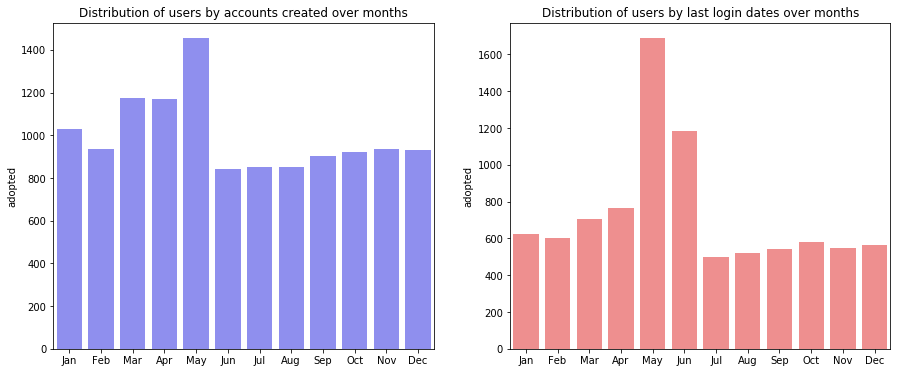

In [22]:
# Analyzing the number of users by accounts created over months
plt.figure(figsize=(15,6))
plt.subplot(121)
creation_by_months = users_updated.groupby('month_creation')['adopted'].count()

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax = sns.barplot(x=months, y=creation_by_months, color='b', alpha=0.5)
plt.title('Distribution of users by accounts created over months')

plt.subplot(122)
last_login_by_months = users_updated.groupby('month_last_login')['adopted'].count()
sns.barplot(months, last_login_by_months, color='r', alpha=0.5) #, ax=ax)
plt.title('Distribution of users by last login dates over months')

Text(0.5, 1.0, 'Distribution of users by last login dates over days of the week')

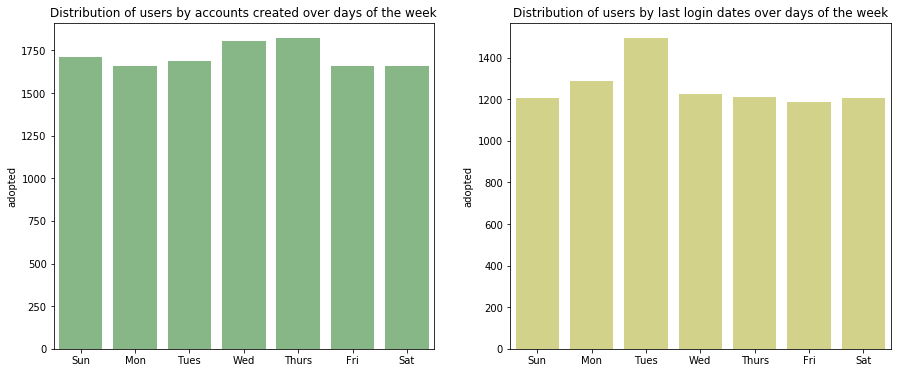

In [23]:
# Analyzing the number of users by accounts created over days of the week
plt.figure(figsize=(15,6))
plt.subplot(121)
creation_by_days = users_updated.groupby('day_of_week_creation')['adopted'].count()

days = ['Sun','Mon','Tues','Wed','Thurs','Fri','Sat']
sns.barplot(x=days, y=creation_by_days, color='g', alpha=0.5)
plt.title('Distribution of users by accounts created over days of the week')

plt.subplot(122)
last_login_by_days = users_updated.groupby('day_of_week_last_login')['adopted'].count()
sns.barplot(days, last_login_by_days, color='y', alpha=0.5)
plt.title('Distribution of users by last login dates over days of the week')

Text(0.5, 1.0, 'Distribution of users by last login dates over hours in a day')

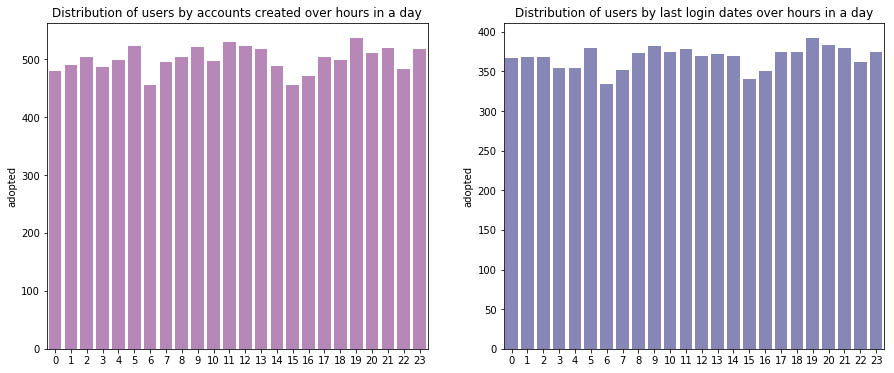

In [24]:
# Analyzing the number of users by accounts created over hours in a day
plt.figure(figsize=(15,6))
plt.subplot(121)
creation_by_hours = users_updated.groupby('hour_creation')['adopted'].count()

hours = [y for y in range(24)]
sns.barplot(x=hours, y=creation_by_hours, color='purple', alpha=0.5)
plt.title('Distribution of users by accounts created over hours in a day')

plt.subplot(122)
last_login_by_hours = users_updated.groupby('hour_last_login')['adopted'].count()
sns.barplot(hours, last_login_by_hours, color='navy', alpha=0.5)
plt.title('Distribution of users by last login dates over hours in a day')

<div class="alert alert-block alert-info">
    As can be seen above, no discernible patterns exist when we consider when the users' accounts were created, or when the last logins took place. These lack of patterns are replicated over the month of the year, day of the week, and hour of the day. It may be safe to say that they don't have as much of an effect on the adopted variable.  Let's perform variable inflation factor analysis to be sure.
</div>


### Multicollinearity Analysis

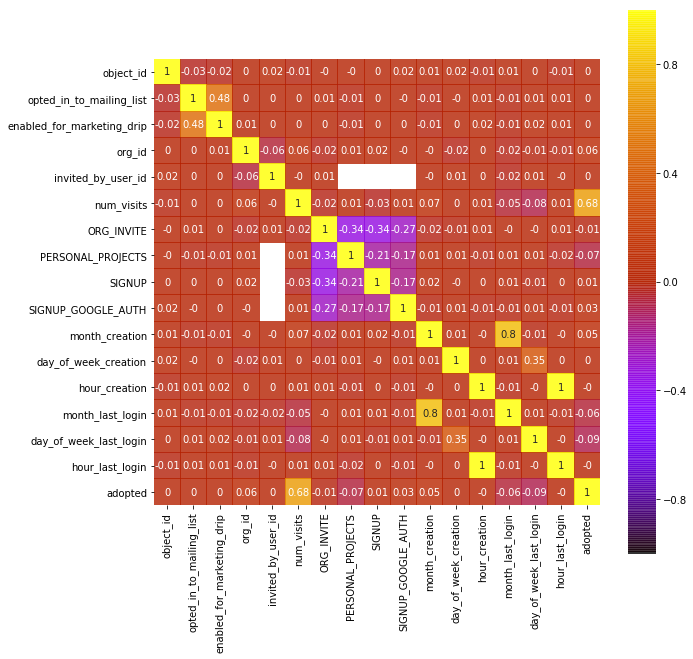

In [25]:
# Correlation matrix
plt.figure(figsize=(10,10))
_ = sns.heatmap(users_updated.corr().round(2),square=True,annot=True,cmap='gnuplot',vmin=-1, vmax=1, alpha=0.8)

We can examine that the highest positive correlation is between the number of visits and the adoption rate (0.68), which may point it to being the best factor. Let us run the VIF analysis to confirm.

In [26]:
# Creating features df and target column
X = users_updated.drop('adopted', axis=1)
y = users_updated['adopted']

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Imputing all null values with zero in X

X.fillna(0, inplace=True)

#Get features
feature_x = X
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
12,9.263204,hour_creation
15,8.374235,hour_last_login
10,6.792516,month_creation
13,6.475073,month_last_login
0,3.557494,object_id


All the VIFs less than 10 represent absence of much multicollinearity present in our data. We're good to move forward with our machine learning model to identify the important features!

### Machine Learning

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [29]:
# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

<div class="alert alert-block alert-info"> 
    To combat the problem of imbalanced classes, as is the case for us (we have about 11% adoption rate), we will employ the SMOTE (Synthetic Minority Over-sampling Technique) technique to synthetically generate samples. 
    </div>

In [30]:
%pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

  Cloning https://github.com/scikit-learn-contrib/imbalanced-learn.git to c:\users\shubh\appdata\local\temp\pip-req-build-71zr3mdf
  Stored in directory: C:\Users\shubh\AppData\Local\Temp\pip-ephem-wheel-cache-m7hk6mgm\wheels\6c\07\cf\38cb9b7cc9e6a0ac7648a80ec192b6f2d863405fb0049ac0ff
Successfully built imbalanced-learn
  Found existing installation: imbalanced-learn 0.6.0.dev0
    Uninstalling imbalanced-learn-0.6.0.dev0:
      Successfully uninstalled imbalanced-learn-0.6.0.dev0
Note: you may need to restart the kernel to use updated packages.


In [31]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

Using TensorFlow backend.


[(0, 8425), (1, 8425)]


### Logistic Regression

In [32]:
# Establishing a baseline for classification results using simple logistic regression. 
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='liblinear',max_iter = 500, random_state=36)

#cross-validate on training set
cv_log_reg = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=5, scoring='f1')

#fitting the model
log_reg.fit(X_train_resampled,y_train_resampled)

#predicting the model values
y_predict = log_reg.predict(X_test)

In [33]:
y_predict.ravel()

array([0, 0, 1, ..., 0, 1, 0])

In [34]:
# Printing out the results of the model
print('Train accuracy: {}'.format(cv_log_reg.mean()))
print('Test accuracy: {}'.format(accuracy_score(y_test, y_predict)))
conf_mat_log_reg = pd.DataFrame(confusion_matrix(y_test, y_predict), columns=['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])
print('Confusion matrix: ')
print(conf_mat_log_reg)
print('Classification report: ')
print(classification_report(y_test, y_predict))

Train accuracy: 0.9872367586621866
Test accuracy: 0.9870833333333333
Confusion matrix: 
          Predicted 0  Predicted 1
Actual 0         2119           24
Actual 1            7          250
Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2143
           1       0.91      0.97      0.94       257

    accuracy                           0.99      2400
   macro avg       0.95      0.98      0.97      2400
weighted avg       0.99      0.99      0.99      2400



### Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model to run 50 estimators
rf = RandomForestClassifier(n_estimators=50, random_state=36)

#Cross-validate on training set
cv_accuracy_rf = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5,scoring='f1')

# train model
rf.fit(X_train_resampled, y_train_resampled)

# predict on test data
y_pred_rf = rf.predict(X_test)

In [36]:
# Printing out the results of the model
print('Train accuracy: {}'.format(cv_accuracy_rf.mean()))
print('Test accuracy: {}'.format(accuracy_score(y_test, y_pred_rf)))
conf_mat_rf = pd.DataFrame(confusion_matrix(y_test, y_pred_rf), columns=['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])
print('Confusion matrix: ')
print(conf_mat_rf)
print('Classification report: ')
print(classification_report(y_test, y_pred_rf))

Train accuracy: 0.9898079116211418
Test accuracy: 0.9854166666666667
Confusion matrix: 
          Predicted 0  Predicted 1
Actual 0         2119           24
Actual 1           11          246
Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2143
           1       0.91      0.96      0.93       257

    accuracy                           0.99      2400
   macro avg       0.95      0.97      0.96      2400
weighted avg       0.99      0.99      0.99      2400



Given the high accuracy and recall from the training results from both logistic regression and the random forest classifier, we can assume the model will give right classification. Let us examine the feature importances. 

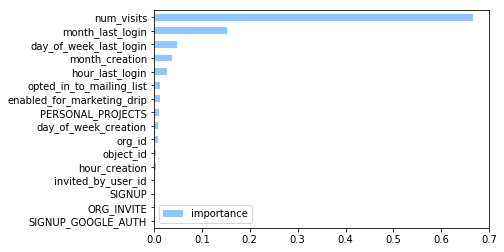

In [37]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, 
                                    columns=['importance']).sort_values('importance',ascending=True)

feature_importances.plot(kind='barh')

<div class="alert alert-block alert-info">
    As was hypothesized, the number of visits greatly influences the adoption of the product by the user. After that, the month of the last login also has a positive correlation with the adoption. 

</div>